In [1]:
# import datasets directly from kaggle via API token
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"ahsang","key":"d3ebeb853bab50eb612332b10793b9a7"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d open-flights/airline-database
!kaggle datasets download -d open-flights/flight-route-database
!kaggle datasets download -d thoudamyoihenba/airports
!kaggle datasets download -d rusiano/european-airports-iata-codes

  0% 0.00/120k [00:00<?, ?B/s]
100% 120k/120k [00:00<00:00, 44.7MB/s]
  0% 0.00/375k [00:00<?, ?B/s]
100% 375k/375k [00:00<00:00, 74.4MB/s]
  0% 0.00/303k [00:00<?, ?B/s]
100% 303k/303k [00:00<00:00, 62.5MB/s]
  0% 0.00/6.49k [00:00<?, ?B/s]
100% 6.49k/6.49k [00:00<00:00, 4.52MB/s]


### Challenges
Initially, the NavBlue provided datasets were missing column headers so the same datasets were fetched from Kaggle with an API key.

The Kaggle approach didn't work because the airport dataset online is missing 2 fields such as Type and Source which are included in the NavBlue dataset.

Hence, the NavBlue datasets were ammended to include column headers with the schema provided. We will now incorporate one extra reference dataset for European Airport IATA codes.

### Problem Statement

We will evaluate the following statistics with respect to Ryanair's share of the European aviation market:
1.   connections
    - number
2.   airports
    -   number
    -   percentage
3.   routes
    -   number
    -   shared
    -   exclusive



In [3]:
# import csv from google drive
from google.colab import drive
drive.mount('/content/drive')
# error datasets missing headers

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Kaggle/Airlines'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle/Airlines/european_iatas_df.csv
/content/drive/MyDrive/Kaggle/Airlines/airlines.csv
/content/drive/MyDrive/Kaggle/Airlines/airports.csv
/content/drive/MyDrive/Kaggle/Airlines/routes.csv


In [5]:
airlines_df = (
    pd.read_csv('/content/drive/MyDrive/Kaggle/Airlines/airlines.csv', 
                header=None, names=['id','name','alias','iata','icao','callsign','country','active'],
                na_values=['\\N', '-', 'NAN', 'unknown'])
    .rename(columns=str.lower)
    .rename(columns=lambda col: '_'.join(col.split()))
    .assign(airline_id=lambda df: df.id.map(str))
)

airlines_df.head()

,id,name,alias,iata,icao,callsign,country,active,airline_id
0,-1,Unknown,NaN,NaN,NaN,NaN,NaN,Y,-1
1,1,Private flight,NaN,NaN,NaN,NaN,NaN,Y,1
2,2,135 Airways,NaN,NaN,GNL,GENERAL,United States,N,2
3,3,1Time Airline,NaN,1T,RNX,NEXTIME,South Africa,Y,3
4,4,2 Sqn No 1 Elementary Flying Training School,NaN,NaN,WYT,NaN,United Kingdom,N,4


In [6]:
airports_df = (
    pd.read_csv('/content/drive/MyDrive/Kaggle/Airlines/airports.csv',
                header=None, names=['id', 'name', 'city', 'country', 'iata', 'icao', 'latitude', 
                                    'longitude', 'altitude', 'timezone', 'dst', 'tz', 'type', 'source'],
                na_values=['\\N', '-', 'NAN', 'unknown'])
    .set_index('id')
    .reset_index(drop=True)
)

eur_airports_iata_df = (
    pd.read_csv('/content/drive/MyDrive/Kaggle/Airlines/european_iatas_df.csv',
                header=None, names=['airport_city', 'airport_name', 'airport_iata'],
                na_values=['\\N', '-', 'NAN', 'unknown'])
)

eur_airports_df = (
    airports_df[airports_df.iata.isin(eur_airports_iata_df.airport_iata)].copy()
    [lambda df: ~df.country.isin(['Russia', 'Turkey'])]
    .reset_index(drop=True))

# del airports_df, eur_airports_iata_df

print('All:', airports_df.shape)
print('Europe:', eur_airports_df.shape)
eur_airports_df.head()

All: (7698, 13)
Europe: (345, 13)


,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz,type,source
0,Akureyri Airport,Akureyri,Iceland,AEY,BIAR,65.660004,-18.072701,6,0.0,N,Atlantic/Reykjavik,airport,OurAirports
1,Keflavik International Airport,Keflavik,Iceland,KEF,BIKF,63.985001,-22.605600,171,0.0,N,Atlantic/Reykjavik,airport,OurAirports
2,Reykjavik Airport,Reykjavik,Iceland,RKV,BIRK,64.129997,-21.940599,48,0.0,N,Atlantic/Reykjavik,airport,OurAirports
3,Antwerp International Airport (Deurne),Antwerp,Belgium,ANR,EBAW,51.189400,4.460280,39,1.0,E,Europe/Brussels,airport,OurAirports
4,Brussels Airport,Brussels,Belgium,BRU,EBBR,50.901402,4.484440,184,1.0,E,Europe/Brussels,airport,OurAirports


In [7]:
routes_df = (
    pd.read_csv('/content/drive/MyDrive/Kaggle/Airlines/routes.csv', 
                header=None, names=['airline', 'airline id', 'source', 'source id', 'destination', 
                                    'destination id', 'codeshare', 'stops', 'equipment'],
                na_values=['\\N', '-', 'NAN', 'unknown'])
    .rename(columns=str.strip)
    .rename(columns=str.lower)
    .rename(columns=lambda v: v.replace(' ', '_'))
    .dropna(subset=['airline_id', 'source_id', 'destination_id'], how='any')
    .assign(airline_id=lambda df: df.airline_id.map(int).map(str),
            source=lambda df: df.source.map(str).map(str),
            source_id=lambda df: df.source_id.map(int).map(str),
            destination=lambda df: df.destination.map(str).map(str),
            destination_id=lambda df: df.destination_id.map(int).map(str),
            route_id=lambda df: df[['source', 'destination']].apply(sorted, axis=1).map('_'.join))
)

eur_routes_df = (
    routes_df[
        routes_df.source.isin(eur_airports_df.iata)
        &
        routes_df.destination.isin(eur_airports_df.iata)
    ].copy()
)

print('All:', routes_df.shape)
print('Europe:', eur_routes_df.shape)
eur_routes_df.head()

All: (66765, 10)
Europe: (14023, 10)


,airline,airline_id,source,source_id,destination,destination_id,codeshare,stops,equipment,route_id
115,2L,2750,BDS,1506,ZRH,1678,NaN,0,100,BDS_ZRH
116,2L,2750,BOD,1264,ZRH,1678,NaN,0,100,BOD_ZRH
117,2L,2750,BRS,490,ZRH,1678,NaN,0,100,BRS_ZRH
118,2L,2750,GVA,1665,LPA,1054,NaN,0,319,GVA_LPA
119,2L,2750,LCA,1197,ZRH,1678,NaN,0,319,LCA_ZRH


In [8]:
eur_routes_df2 = (
    eur_routes_df
    .pipe(pd.merge, 
          airlines_df[['id', 'icao', 'name', 'country']],
          left_on=['source'], right_on=['icao'], how='left')
    .pipe(pd.merge, 
          eur_airports_df[['iata', 'country', 'city', 'latitude', 'longitude']]
          .rename(columns=lambda col: 'source_' + col),
          left_on=['source'], right_on=['source_iata'], how='left')
    .pipe(pd.merge, 
          eur_airports_df[['iata', 'country', 'city', 'latitude', 'longitude']]
          .rename(columns=lambda col: 'destination_' + col),
          left_on=['destination'], right_on=['destination_iata'], how='right')
    .assign(is_national_route=lambda df: df.source_country == df.destination_country)
    .assign(dist=lambda df: np.sqrt(
        (df.destination_longitude - df.source_longitude) ** 2 
        + (df.destination_latitude - df.source_latitude) ** 2))
)

eur_routes_df2.sort_values(by='airline', ascending=True).value_counts('airline')

airline
FR    2270
U2    1012
AB     612
DY     506
IB     500
      ... 
XQ       1
EW       1
TS       1
U6       1
KQ       1
Length: 154, dtype: int64

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# ensure white background
plt.rcParams['figure.facecolor'] = 'w'

In [13]:
n_connections_srs = (
    eur_routes_df2
    .groupby('airline')
    .route_id
    .nunique()
    .sort_values()[::-1]
    .rename('# Unique Connections')
    .rename_axis('Airline')
)

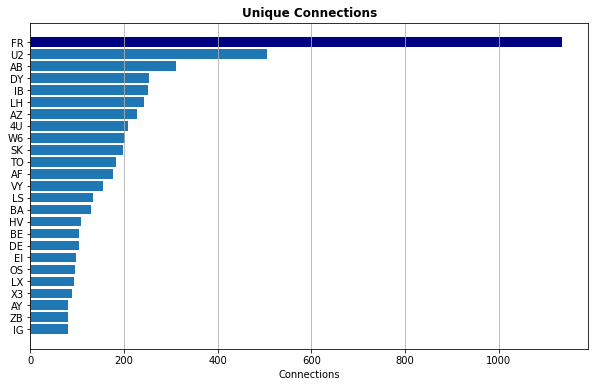

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

ax.barh(n_connections_srs.index[:25][::-1], n_connections_srs[:25][::-1])
ax.barh('FR', n_connections_srs['FR'], color='navy')

ax.set_xlabel('Connections')

ax.set_title('Unique Connections', weight='bold')
ax.grid(axis='x')
plt.show()

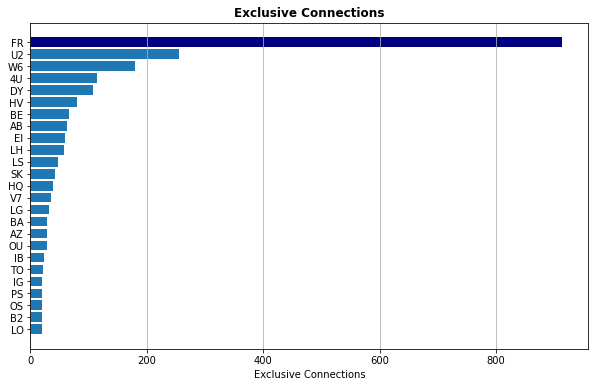

In [15]:
n_exclusive_connections_srs = (
    eur_routes_df2
    .groupby('route_id')
    .airline_id
    .nunique()
    [lambda srs: srs == 1]
    .reset_index()
    .pipe(pd.merge, eur_routes_df2[['route_id', 'airline']], how='left')
    .groupby('airline')
    .route_id
    .nunique()
    .sort_values()[::-1]
    .rename('# Exclusive Connections')
    .rename_axis('Airline')
)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(n_exclusive_connections_srs.index[:25][::-1], n_exclusive_connections_srs[:25][::-1])
ax.barh('FR', n_exclusive_connections_srs.loc['FR'], color='navy')
ax.set_xlabel('Exclusive Connections')
ax.set_title('Exclusive Connections', weight='bold')
ax.grid(axis='x')

plt.show()

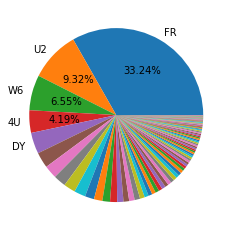

In [16]:
fig, ax = plt.subplots()

ax.pie(n_exclusive_connections_srs, autopct=lambda pct: ('%.2f' % pct) + '%' if pct > 4 else '',
       labels=[al if i < 5 else '' for i, al in enumerate(n_exclusive_connections_srs.index)])

plt.show()

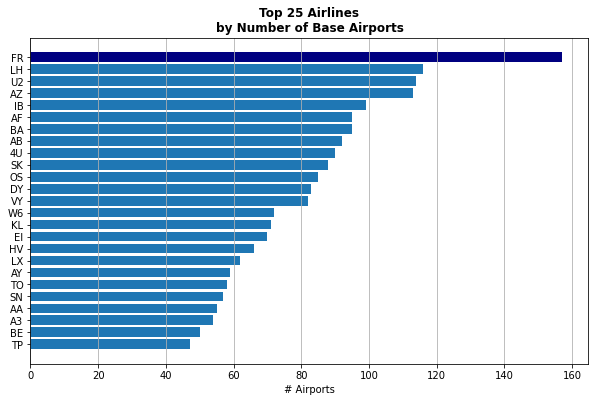

In [17]:
n_airports_srs = (
    eur_routes_df2
    .groupby('airline')
    .source_id
    .nunique()
    .sort_values()[::-1]
    .rename('# Airports')
    .rename_axis('Airline')
)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(n_airports_srs.index[:25][::-1], n_airports_srs[:25][::-1])
ax.barh('FR', n_airports_srs.loc['FR'], color='navy')
ax.set_xlabel('# Airports')
ax.set_title('Top 25 Airlines\nby Number of Base Airports', weight='bold')
ax.grid(axis='x')

plt.show()

In [18]:
n_airports_srs.head()

Airline
FR    157
LH    116
U2    114
AZ    113
IB     99
Name: # Airports, dtype: int64

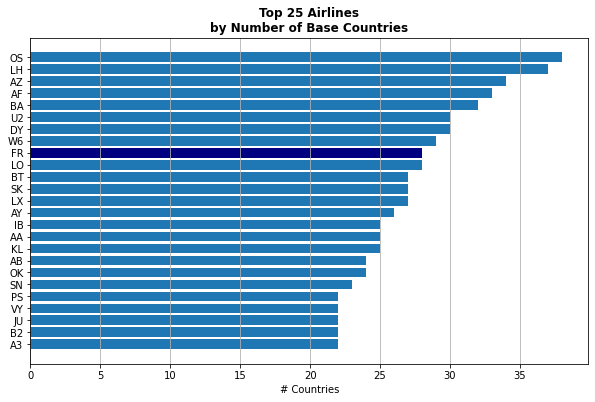

In [19]:
n_countries_srs = (
    eur_routes_df2
    .groupby('airline')
    .source_country
    .nunique()
    .sort_values()[::-1]
    .rename('# Countries')
    .rename_axis('Airline')
)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh(n_countries_srs.index[:25][::-1], n_countries_srs[:25][::-1])
ax.barh('FR', n_countries_srs.loc['FR'], color='navy')
ax.set_xlabel('# Countries')
ax.set_title('Top 25 Airlines\nby Number of Base Countries', weight='bold')
ax.grid(axis='x')

plt.show()

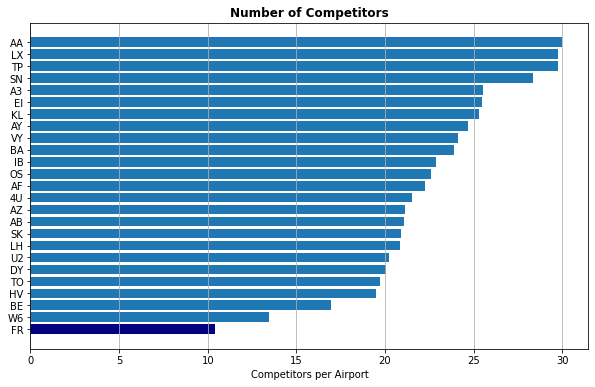

In [20]:
n_competitors_df = (
    eur_routes_df2.groupby('source_id')
    .airline_id.nunique().sub(1)
    .to_frame('n_competitors')
    .reset_index()
    .pipe(pd.merge, eur_routes_df2[['source_id', 'airline']].drop_duplicates())
)

avg_competitors_srs = (
    n_competitors_df
    .groupby('airline')
    .n_competitors
    .mean()
    .sort_values()[::-1]
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(*list(zip(*list(avg_competitors_srs.reindex(index=n_airports_srs.index[:25]).sort_values().iteritems()))))
ax.barh('FR', avg_competitors_srs.loc['FR'], color='navy')
ax.set_xlabel('Competitors per Airport')
ax.set_title('Number of Competitors', weight='bold')
ax.grid(axis='x')

plt.show()

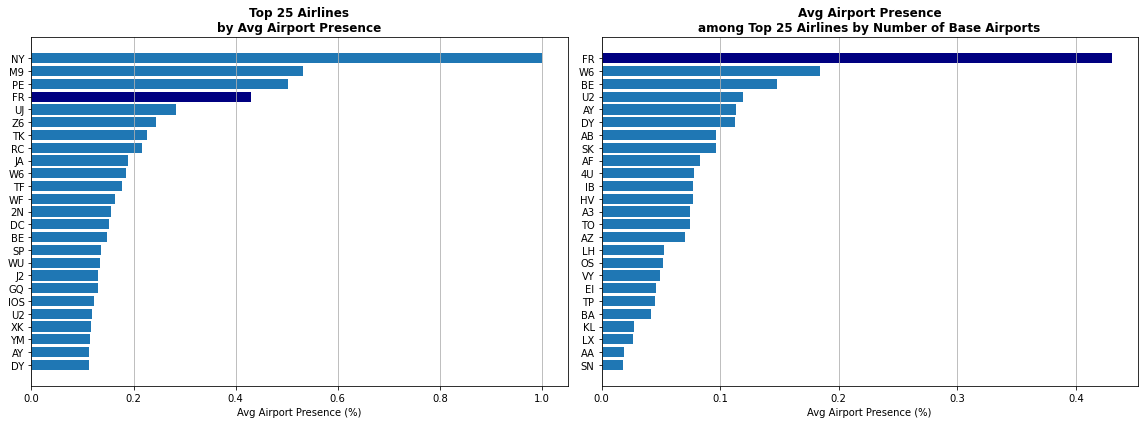

In [21]:
airport_presence_df = (
    eur_routes_df2
    .groupby('source_id')
    .airline
    .apply(lambda srs: srs.value_counts(normalize=True).rename_axis('airline'))
    .rename('airport_presence')
    .reset_index()
)

avg_airport_presence_df = (
    airport_presence_df
    .groupby('airline')
    .airport_presence.mean()
    .sort_values()[::-1]
)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16,6))

ax.barh(avg_airport_presence_df.index[:25][::-1], avg_airport_presence_df[:25][::-1])
ax.barh('FR', avg_airport_presence_df.loc['FR'], color='navy')
ax.set_xlabel('Avg Airport Presence (%)')
ax.set_title('Top 25 Airlines\nby Avg Airport Presence', weight='bold')
ax.grid(axis='x')

avg_presence_for_top25_airlines_by_airports = avg_airport_presence_df.reindex(index=n_airports_srs.index[:25]).sort_values()
ax1.barh(avg_presence_for_top25_airlines_by_airports.index, avg_presence_for_top25_airlines_by_airports)
ax1.barh('FR', avg_airport_presence_df.loc['FR'], color='navy')
ax1.set_xlabel('Avg Airport Presence (%)')
ax1.set_title('Avg Airport Presence\namong Top 25 Airlines by Number of Base Airports', weight='bold')
ax1.grid(axis='x')

plt.tight_layout()
plt.show()

In [22]:
avg_airport_presence_df.head()

airline
NY    1.000000
M9    0.531250
PE    0.502066
FR    0.430619
UJ    0.282212
Name: airport_presence, dtype: float64